       Airline Date_of_Journey    Source Destination                  Route  \
0       IndiGo      24/03/2019  Banglore   New Delhi              BLR → DEL   
1    Air India       1/05/2019   Kolkata    Banglore  CCU → IXR → BBI → BLR   
2  Jet Airways       9/06/2019     Delhi      Cochin  DEL → LKO → BOM → COK   
3       IndiGo      12/05/2019   Kolkata    Banglore        CCU → NAG → BLR   
4       IndiGo      01/03/2019  Banglore   New Delhi        BLR → NAG → DEL   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897  
1    05:50         13:15   7h 25m     2 stops         No info   7662  
2    09:25  04:25 10 Jun      19h     2 stops         No info  13882  
3    18:05         23:30   5h 25m      1 stop         No info   6218  
4    16:50         21:35   4h 45m      1 stop         No info  13302  
Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata  

<AxesSubplot:>

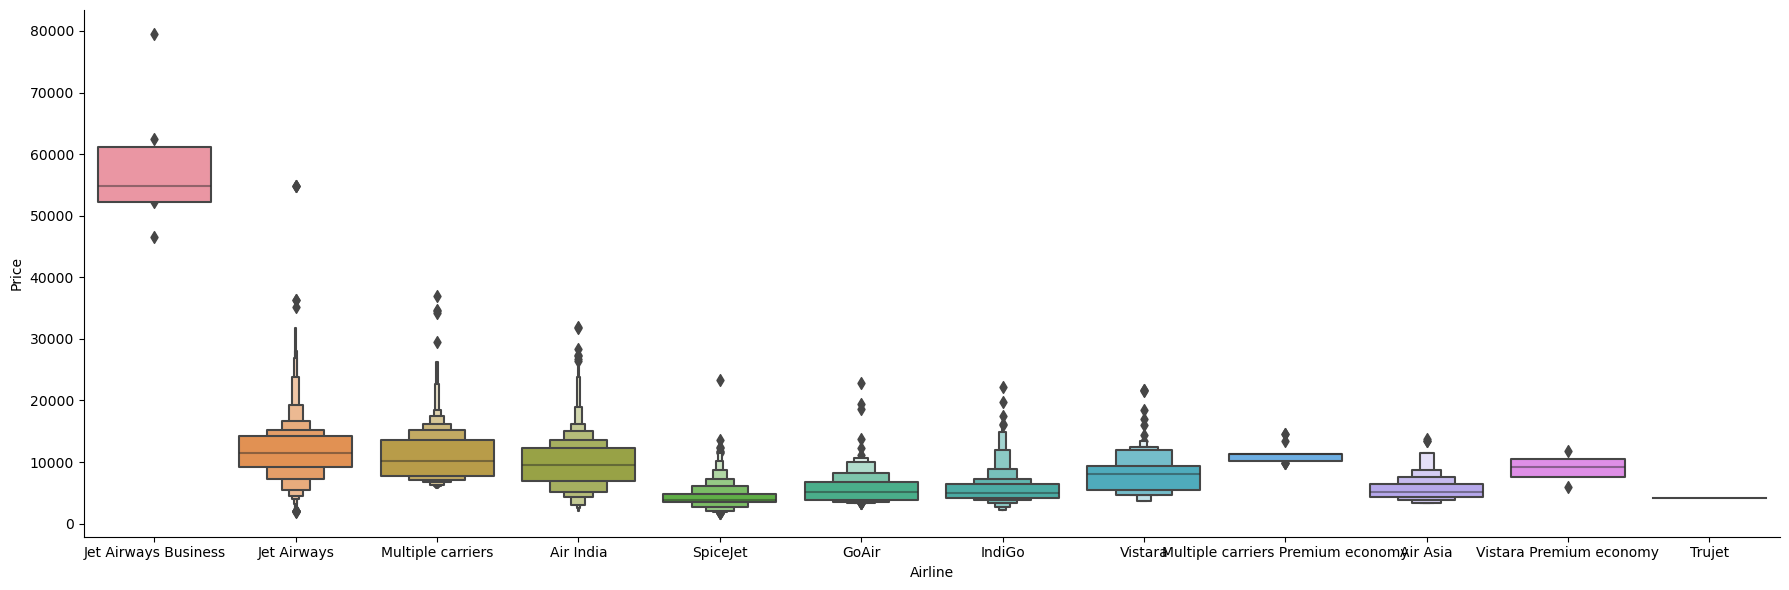

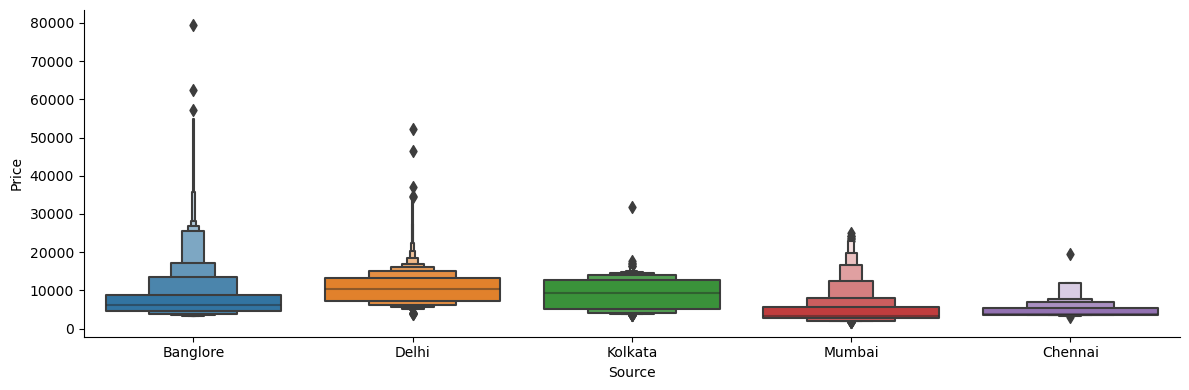

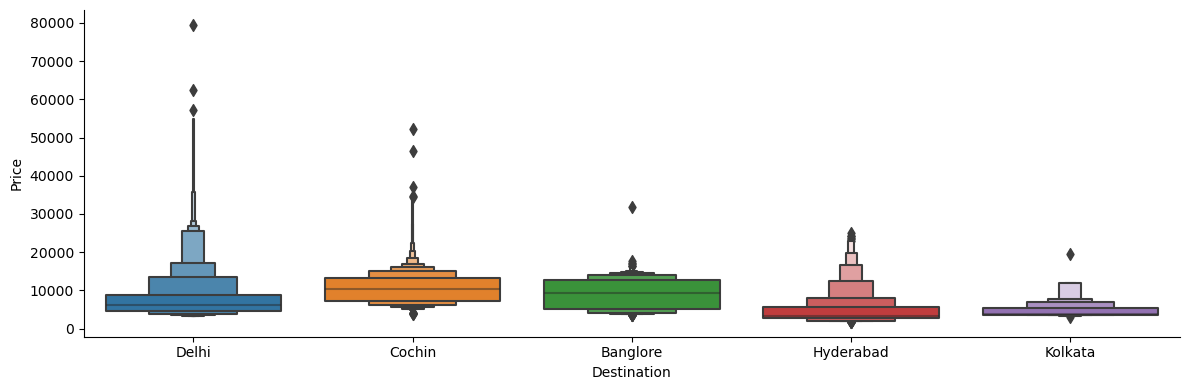

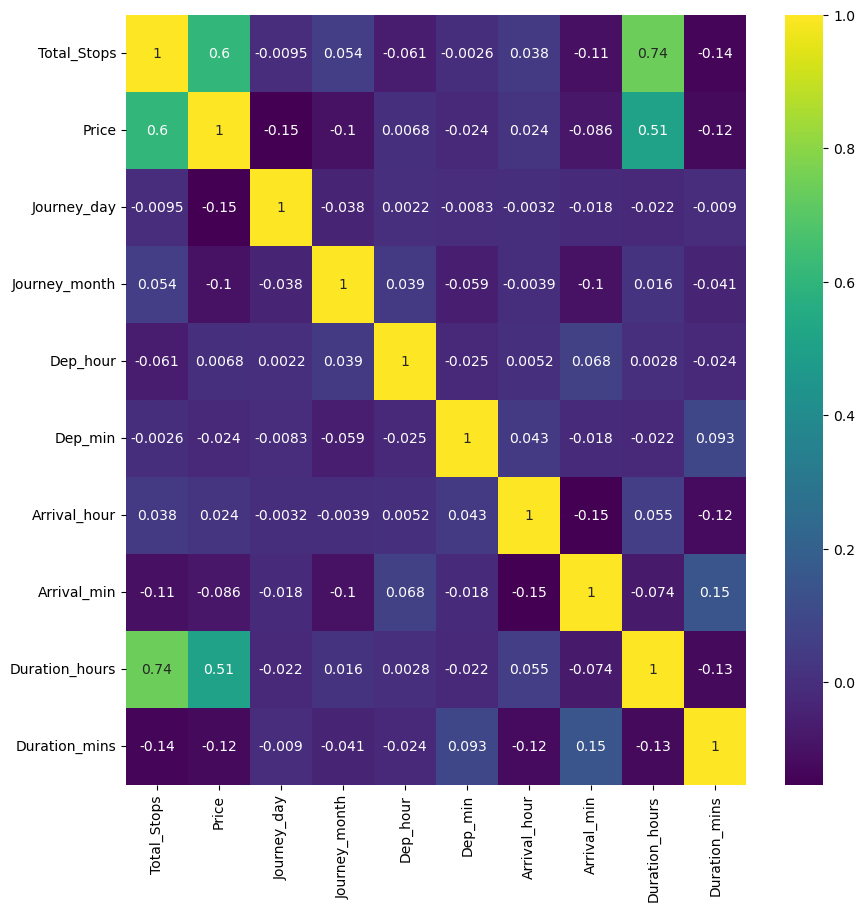

In [1]:
#start date: 11/03/2024
#project_title: Flight Price Prediction with Flask app – with source code – data visualizations – interesting project – 2024
#project_link:

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import pickle

#Reading training data
train_data = pd.read_excel('Data_Train.xlsx')
print(train_data.head())

#checking values
print(train_data['Destination'].value_counts())

#Merging Delhi and New Delhi
def newd(x):
    if x == 'New Delhi':
        return 'Delhi'
    else:
        return x

train_data['Destination'] = train_data['Destination'].apply(newd)

print(train_data.info())

#Making Datetime columns with day and month
train_data['Journey_day'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d/%m/%Y').dt.day
train_data['Journey_month'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d/%m/%Y').dt.month
train_data.drop('Date_of_Journey',inplace=True,axis=1)
print(train_data.head())

#Extracting hours and minutes from time
train_data['Dep_hour'] = pd.to_datetime(train_data['Dep_Time']).dt.hour
train_data['Dep_min'] = pd.to_datetime(train_data['Dep_Time']).dt.minute
train_data.drop('Dep_Time',axis=1,inplace=True)

train_data['Arrival_hour'] = pd.to_datetime(train_data['Arrival_Time']).dt.hour
train_data['Arrival_min'] = pd.to_datetime(train_data['Arrival_Time']).dt.minute
train_data.drop('Arrival_Time',axis=1,inplace=True)

print(train_data.head())
print(train_data['Duration'].value_counts())

#Dropping the Duration column and extracting important info from it
duration = list(train_data['Duration'])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:
        if 'h' in duration[i]:
            duration[i] = duration[i] + ' 0m'
        else:
            duration[i] = '0h ' + duration[i]

duration_hour = []
duration_min = []

for i in duration:
    h,m = i.split()
    duration_hour.append(int(h[:-1]))
    duration_min.append(int(m[:-1]))

train_data['Duration_hours'] = duration_hour
train_data['Duration_mins'] = duration_min

train_data.drop('Duration',axis=1,inplace=True)
print(train_data.head())

#Plotting Airline vs Price
sns.catplot(x='Airline', y='Price',data = train_data.sort_values('Price', ascending=False), kind='boxen', aspect=3, height=6)

#Create dummy columns out of the Airline column
airline = train_data[['Airline']]
airline = pd.get_dummies(airline, drop_first=True)
#Plotting Source vs Price
# If we are going from Banglore the prices are slightly higher as compared to other cities
sns.catplot(x='Source', y='Price', data = train_data.sort_values('Price', ascending=False), kind='boxen', aspect=3, height=4)

#Create dummy columns out of the Source column.
source = train_data[['Source']]
source = pd.get_dummies(source, drop_first=True)
print(source.head())
#Plotting Destination vs Price.
# If we are going to New Delhi the prices are slightly higher as compared to other cities
sns.catplot(x='Destination', y='Price', data = train_data.sort_values('Price', ascending=False), kind='boxen', aspect=3, height=4)

#Create dummy columns out of the Destination column
destination = train_data[['Destination']]
destination = pd.get_dummies(destination, drop_first=True)
print(destination.head())

#Dropping crap columns
train_data.drop(['Route','Additional_Info'], inplace=True, axis=1)

#Checking values in the Total stops column
print(train_data['Total_Stops'].value_counts())

#Converting labels into numbers in the Total_stops column
# acc to the data, price is directly prop to the no. of stops
train_data['Total_Stops'].replace({'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4},inplace=True)
print(train_data.head())

#Checking the shapes of our 4 data frames
print(airline.shape)
print(source.shape)
print(destination.shape)
print(train_data.shape)

#Combine all 4 data frames
data_train = pd.concat([train_data, airline,source, destination], axis=1)
data_train.drop(['Airline', 'Source', 'Destination'], axis=1, inplace=True)
print(data_train.head())

#Taking out train data
X = data_train.drop('Price', axis=1)
print(X.head())

#Take out train data labels
y = data_train['Price']
print(y.head())

#Checking correlations between columns
plt.figure(figsize=(10,10))
sns.heatmap(train_data.corr(),cmap='viridis',annot=True)

#First try out the ExtraTreesRegressor model for Flight Price Prediction
reg = ExtraTreesRegressor()
reg.fit(X,y)
print(reg.feature_importances_)

#Checking feature importance given by ExtraTreeRegressor
plt.figure(figsize = (12,8))
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

#stop date: 05/04/2024
#end date: